goal:

- use librosa on 1000 audio files and/or 50 class folders minimum
- store information in a dataframe (excluding actual file data for now)
  - folder name, file name, sampling rate, data length, file length, file size(?)

In [1]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchaudio
import copy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from tqdm import tqdm
from IPython.display import Audio

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from imblearn.over_sampling import RandomOverSampler

from math import floor

torch.set_printoptions(sci_mode=False)

In [2]:
# experimental parameters for model training, for simple configuration in a single cell.
# very useful for reporting spreadsheet

on_sciama = True # for changing source directory

folder_key = {}

split_interval_secs = 2
split_length = 10000000000000 # absurd number for future use
sample_rate = 32000

variance_threshold = 0.2
mean_threshold = 5

total_folders = 50
min_rating = 5.0
max_files_per_folder = 20

sampling_technique = "median"

test_size = 0.2

epochs = 500
batch_size = 1024
dropout_rate = 0.5
learning_rate = 0.001
momentum = 0
experimental = False
experimental_counter_limit = 10
save_best_to_file = False

In [3]:
if on_sciama:
    base_path = "/mnt/lustre/peprmint/train_audio/"
else:
    base_path = "../../datasets/birdsongs-combined/train_audio/"

In [4]:
def reset_seed():
    torch.manual_seed(1368)
    random.seed(1368)
    np.random.seed(1368)

reset_seed()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).total_memory)

print(device)
print(torch.cuda.get_device_name())

85094825984
cuda
NVIDIA A100 80GB PCIe


In [6]:
# base_dir: directory of all the audio file folders
# split_interval_secs: the length of each sound clip when split up in a file.
#   - final dataframe will not contain any sound clips over/under this length
# sample_rate: sample rate of sound clips in hz
# total_folders: total folders to iterate through the files, given range of files per folder
# min_files_per_folder: minimum files to exist in the folder
# max_files_per_folder: maximum files to use inside the folder
def get_random_folders_filtered(base_dir: str, split_interval_secs: float, sample_rate: int = 32000, total_folders: int = 50, max_files_per_folder: int = -1, min_rating: float = 4.0):
    global split_length, folder_key

    # get the list of valid folders and files to analyse
    folder_key = {}

    folders = []
    valid_folders = set()
    valid_files = set([l.replace("\n", "") for l in open(f"rating_thresholds_at_least_10_classes/min_rating_{int(min_rating * 2)}.txt").readlines()])
    for f in valid_files: valid_folders.add(f.split("/")[0])
    for folder in [line.replace("\n", "") for line in open("folder_order.txt").readlines()]:
        if folder in valid_folders:
            folders.append(folder)

    folder_count = 0

    # if there are less folders than those specified, view all folders instead of given amount
    total_folders = min(len(folders), total_folders)

    rows = []
    
    for folder in folders:
        
        folder_path = base_dir + folder + "/"
        valid_folder_files = []
        # only iterate through the valid audio files
        for file in os.listdir(folder_path):
            if folder + "/" + file in valid_files:
                valid_folder_files.append(folder_path + file)
        random.shuffle(valid_folder_files)

        if max_files_per_folder > 0:
            valid_folder_files = valid_folder_files[:min(max_files_per_folder, len(valid_folder_files))]

        # iterate through each file in the folder
        for file_path in (progress_bar := tqdm(valid_folder_files)):
            # load file data and resample to sample_rate if necessary
            file_data, file_sample_rate_hz = torchaudio.load(uri=file_path, channels_first=True)
            if file_sample_rate_hz != sample_rate:
                file_data = torchaudio.functional.resample(file_data, orig_freq=file_sample_rate_hz, new_freq=sample_rate)

            # convert all audio into mono (1 channel) if audio is stereo (2 channels)
            if file_data.shape[0] == 2:
                file_data = file_data.mean(dim=0)
            else:
                file_data = file_data.flatten()

            # get total number of X second splits
            total_splits = floor(len(file_data) / int(sample_rate * split_interval_secs))
            
            # convert file data into mel-spectrogram fourier transform for feeding into CNN
            n_fft = 1024



            mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate = sample_rate, power=2, n_fft=n_fft)
            
            # OLD MEL-SPECTROGRAM TRANSFORMATION
            # amp_to_db_transform = torchaudio.transforms.AmplitudeToDB(stype="amplitude", top_db=80)
            # mel_spec_data_db = amp_to_db_transform(mel_spec_transform(file_data)).numpy()
            
            # NEW MEL-SPECTROGRAM TRANSFORMATION
            mel_spec_data_db = torchaudio.functional.amplitude_to_DB(mel_spec_transform(file_data), multiplier=20., amin=0, db_multiplier=1, top_db=80).numpy()
            mel_spec_data_db = mel_spec_data_db - mel_spec_data_db.min()
            

            
            # if file is at least X seconds.
            if total_splits >= 1:
                split_length = min(mel_spec_data_db.shape[1] // total_splits, split_length)
                mel_spec_splits = np.arange(0, mel_spec_data_db.shape[1], split_length)
                for i in range(len(mel_spec_splits) - 1):
                    start = mel_spec_splits[i]
                    end = mel_spec_splits[i + 1]

                    mel_spec_split = mel_spec_data_db[:, start:end]

                    row = {}
                    row["folder"] = folder
                    row["file"] = file_path.split("/")[-1]
                    row["mel_spec"] = mel_spec_split
                    row["mel_spec_shape"] = mel_spec_split.shape

                    # determine and filter for "silence":
                    var = np.var(mel_spec_split)
                    mean = np.mean(mel_spec_split)

                    # for identifying and removing/changing silent noise
                    if mean <= mean_threshold and var <= variance_threshold:
                        #row["folder"] = "SILENT"
                        continue
                        
                    rows.append(row)

                folder_key[folder_count] = folder
            
            progress_bar.set_description(f"Folder {folder_count + 1}/{total_folders} - {folder}")
        
        # end loop if total_folders has been reached
        folder_count += 1
        if folder_count >= total_folders: break

    # trim the ends of some mel spectrograms because of stupid floating point nonsense
    for i, row in enumerate(rows):
        if row["mel_spec_shape"][1] != split_length:
            row["mel_spec"] = row["mel_spec"][:, :split_length]
            row["mel_spec_shape"] = row["mel_spec"].shape

    folder_key[total_folders] = "SILENT"

    return pd.DataFrame(rows)

In [7]:
reset_seed()

folder_df = get_random_folders_filtered(
    base_path, 
    split_interval_secs=split_interval_secs, 
    sample_rate=sample_rate,
    total_folders=total_folders,
    min_rating=min_rating,
    max_files_per_folder=max_files_per_folder
)

Folder 50/50 - grycat: 100%|██████████| 20/20 [00:01<00:00, 15.90it/s]


In [8]:
folder_df.head()

,folder,file,mel_spec,mel_spec_shape
0,dowwoo,XC193421.mp3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","(128, 125)"
1,dowwoo,XC567618.ogg,"[[0.0, 36.02008, 26.751236, 23.641407, 22.4456...","(128, 125)"
2,dowwoo,XC567618.ogg,"[[27.363564, 13.680376, 0.0, 22.012474, 21.678...","(128, 125)"
3,dowwoo,XC567618.ogg,"[[32.70469, 21.065228, 16.680084, 0.0, 16.7129...","(128, 125)"
4,dowwoo,XC567618.ogg,"[[25.229847, 11.055428, 16.052992, 28.415756, ...","(128, 125)"


In [9]:
folder_df["mel_spec_shape"].value_counts()

mel_spec_shape
(128, 125)    18718
Name: count, dtype: int64

In [10]:
folder_df["folder"].value_counts()

folder
banswa     1457
logshr      824
yehbla      663
redcro      594
grycat      590
cubthr      576
comyel      509
scbwre1     495
mitpar      489
compau      458
verdin      442
combuz1     436
whbman1     419
bkskit1     414
indbun      409
pirfly1     407
phaino      402
eucdov      400
buwwar      391
mawthr1     391
cobtan1     388
dowwoo      384
annhum      382
sheowl      376
peflov      363
bkbmag1     355
brncre      351
royter1     342
brnjay      319
whiwre1     315
spotow      310
rerswa1     297
barswa      288
combul2     287
yehcar1     282
oliwoo1     263
ocbfly1     245
piebus1     244
blhpar1     242
amtspa      224
lotduc      212
insowl1     209
yebsap      206
leater1     188
comloo      188
zebdov      171
amepip      160
blkfra      142
litegr      118
brubru1     101
Name: count, dtype: int64

In [11]:
print("sound clips BEFORE any sampling:", len(folder_df))

sound clips BEFORE any sampling: 18718


In [12]:
len(folder_df["folder"].unique())

50

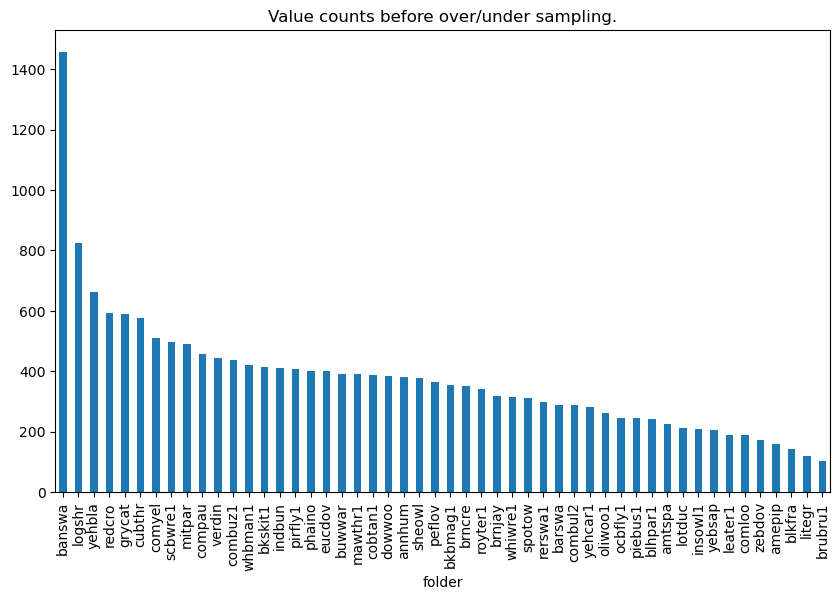

In [13]:
plt.figure(figsize=(max(10, total_folders // 8), 6))
folder_df["folder"].value_counts().plot.bar(title="Value counts before over/under sampling.")
plt.show()

In [14]:
# apply random undersampling OR oversampling

reset_seed()

if sampling_technique == "under":
    # random "naive" undersampling
    # delete random rows from all classes except minority class(es)
    min_folder_count = min(folder_df["folder"].value_counts())

    indices_to_keep = np.array([])

    for f in folder_df["folder"].unique():
        indices_to_keep = np.concat([np.random.choice(folder_df[folder_df["folder"] == f].index, size=min_folder_count), indices_to_keep])

    folder_df = folder_df.loc[indices_to_keep]
    folder_df.reset_index(drop=True, inplace=True)

if sampling_technique == "over":
    ros = RandomOverSampler(random_state=1368)

    # print how much each class will increase by (relative to its current size)
    max_folder = max(folder_df["folder"].value_counts())
    for folder, count in folder_df["folder"].value_counts().sort_values(ascending=True).items():
        print(f"{folder} will increase by {round((max_folder / count - 1) * 100, 2)}%")

    folder_df = pd.concat(ros.fit_resample(folder_df.drop("folder", axis=1), folder_df["folder"]), axis=1)
    # moves "folder" to other side of df but shouldn't affect anything

if sampling_technique == "median":
    # take the median value of folder counts
    # under sample all above the median
    # over smaple all below the median

    ros = RandomOverSampler(random_state=1368)
    median_folder_count = round(folder_df["folder"].value_counts().median())
    indices_to_keep = np.array([])

    print("median:", median_folder_count)

    for f in folder_df["folder"].unique():
        folder_length = len(folder_df[folder_df["folder"] == f])
        if folder_length > median_folder_count:
            indices_to_keep = np.concat([np.random.choice(folder_df[folder_df["folder"] == f].index, size=median_folder_count), indices_to_keep])
        else:
            indices_to_keep = np.concat([folder_df[folder_df["folder"] == f].index, indices_to_keep])
        
    folder_df = folder_df.loc[indices_to_keep]
    folder_df.reset_index(drop=True, inplace=True)
    
    folder_df = pd.concat(ros.fit_resample(folder_df.drop("folder", axis=1), folder_df["folder"]), axis=1)

median: 359


<Axes: title={'center': 'Value counts after median sampling.'}, xlabel='folder'>

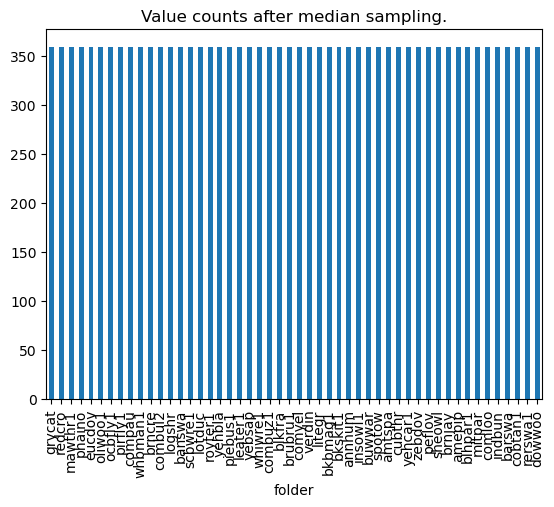

In [15]:
folder_df["folder"].value_counts().plot.bar(title=f"Value counts after {sampling_technique} sampling.")

In [16]:
print("sound clips AFTER sampling:", len(folder_df))

sound clips AFTER sampling: 17950


(128, 125)


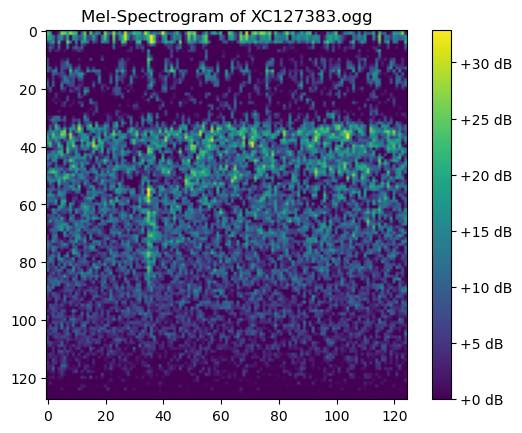

(128, 125)


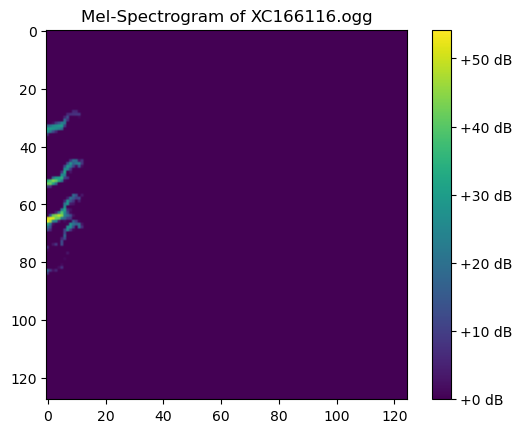

(128, 125)


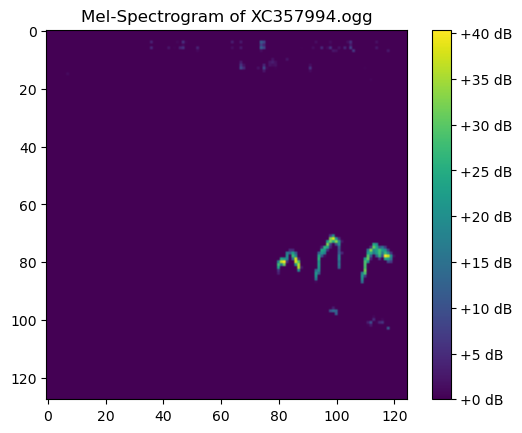

In [17]:
# plot 5 random mel spectrograms
# checks for consistency in scaling and whatnot

reset_seed()

sample_spec_indices = random.sample(folder_df.index.tolist(), k=3)

for i in sample_spec_indices:
    row = folder_df.iloc[i]
    
    print(row["mel_spec_shape"])
    
    plt.figure()
    plt.imshow(row["mel_spec"])
    plt.title(f"Mel-Spectrogram of {'/'.join(row['file'].split('/')[-2:])}")
    plt.colorbar(format='%+2.0f dB')
    plt.show()

del row

In [18]:
# input shape needs to be AxBxCxD
# A = list of files
# B = depth of each one (currently just 1, as it only contains 1 value. if colours are used then maybe up it to 3)
# CxD = input width/height (128x626 etc)
if "mel_spec" in folder_df.columns:
    print("step 1")
    x = folder_df["mel_spec"]
    print("step 2")
    folder_df.drop("mel_spec", axis=1, inplace=True)
    print("step 3")
    x = np.stack(x)
    print("step 4")
    x = torch.from_numpy(x)
    print("step 5")
    x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
    print("step 6")
    x = x.to(device)

print("step 7")
le = LabelEncoder()
print("step 8")
y = torch.LongTensor(le.fit_transform(folder_df["folder"]))
print("step 9")
y = y.to(device)

step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9


In [19]:
reset_seed()

x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, test_size=test_size, random_state=1368)

del x, y

In [20]:
# iteration 3.0

class TestModel(nn.Module):
    global folder_df

    def __init__(self, input_shape: torch.Size, dropout_rate: float = 0):
        super().__init__()

        total_output_classes = len(folder_df["folder"].unique())

        # input shape should be some list/tuple of length 4
        if len(input_shape) != 4: return Exception("Input shape is not AxBxCxD.")
        
        A = input_shape[0]
        B = input_shape[1]
        C = input_shape[2]
        D = input_shape[3]

        self.relu = nn.ReLU6() # relu does not have trainable parameters, thus, can be reused

        self.conv1 = nn.Conv2d(in_channels=B, out_channels=10, kernel_size=(3, 3))
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.drop1 = nn.Dropout(p=dropout_rate)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.drop2 = nn.Dropout(p=dropout_rate)
        self.flat = nn.Flatten()

        flatten_nodes = 10 * ((((C - 2) // 2) - 2) // 2) * ((((D - 2) // 2) - 2) // 2)
        
        self.norm = nn.BatchNorm1d(num_features=flatten_nodes)
        self.linear1 = nn.Linear(in_features=flatten_nodes, out_features=1024)
        self.linear2 = nn.Linear(in_features=1024, out_features=512)
        self.linear3 = nn.Linear(in_features=512, out_features=128) 
        self.output = nn.Linear(in_features=128, out_features=total_output_classes)

    def forward(self, x):
        # define calculations here
        x = self.conv1(x)
        x = self.relu(x)

        x = self.pool1(x)
        x = self.drop1(x)

        x = self.conv2(x)
        x = self.relu(x)

        x = self.pool2(x)
        x = self.drop2(x)

        x = self.flat(x)
        x = self.norm(x)

        x = self.linear1(x)
        x = self.relu(x)

        x = self.linear2(x)
        x = self.relu(x)

        x = self.linear3(x)
        x = self.relu(x)

        x = self.output(x)
        x = self.relu(x)

        return x

In [21]:
# model: the model to train
# loss_fn: the loss function to update weights
# optimizer: the optimiser function to affect rate of change
# epochs: number of epochs to train the model over
# batch_size: samples to train x_train and y_train to avoid memory issues
# save_best_to_file: save model with highest test accuracy to models/ folder.
# experimental: whether to end training after 5 consecutive runs of no higher test accuracy.
#       - training ends when either [epochs] epochs have been run, *OR* if 5 consecutive runs do not improve test accuracy from previous best.

def train_model(model, loss_fn, optimizer, epochs, batch_size, save_best_to_file = False, experimental = False):
    global x_train, y_train
    batch_indices = np.linspace(0, len(x_train), int(len(x_train) / batch_size), dtype="int")

    train_loss_hist = []
    train_acc_hist = []
    test_acc_hist = []

    best_test_acc = 0
    best_model = None

    experimental_counter = 0

    for epoch in range(1, epochs + 1):
        model.train()

        train_acc = 0
        
        for i in range(len(batch_indices) - 1):
            start_index = batch_indices[i]
            stop_index = batch_indices[i + 1]

            x_batch = x_train[start_index:stop_index]
            y_batch = y_train[start_index:stop_index]

            x_batch, y_batch = shuffle(x_batch, y_batch)

            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            train_acc += sum(torch.argmax(y_pred, dim=1) == y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_acc = train_acc * 100 / len(y_train)

        model.eval()
        test_acc = sum(torch.argmax(model(x_test), dim=1) == y_test) * 100 / len(y_test)

        print(f"Epoch {epoch}: train loss = {loss:.04f}, train acc = {train_acc:.02f}%, test acc = {test_acc:.02f}% {"!!" if test_acc > best_test_acc else ""}")

        train_loss_hist.append(float(loss.cpu().detach().numpy()))
        train_acc_hist.append(float(train_acc.cpu().detach().numpy()))
        test_acc_hist.append(float(test_acc.cpu().detach().numpy()))

        if experimental:
            experimental_counter += 1

        if test_acc > best_test_acc:
            experimental_counter = 0
            best_test_acc = test_acc
            
            # overwrite best model with new best model
            best_model = copy.deepcopy(model.state_dict())

        if experimental_counter == experimental_counter_limit:
            print(f"Experimental Mode ended the training early, as the testing accuracy had not increased over {experimental_counter_limit} consecutive epochs.")
            break
        
    if save_best_to_file:
        model_save_path = "models/"
        if not os.path.exists(model_save_path): os.mkdir(model_save_path)
        file_number = len(os.listdir(model_save_path)) + 1
        file_name = f"best_model_{file_number:>03}"
        best_model_path = model_save_path + file_name + ".pth"

        torch.save(best_model, best_model_path)

    plt.figure(figsize=(12,8))
    pd.Series(train_acc_hist).plot.line(label="Train", color="blue")
    pd.Series(test_acc_hist).plot.line(label="Test", color="red")
    plt.legend()
    plt.ylim((0, 100))
    plt.yticks(np.arange(0, 101, 10))
    plt.title(f"Convolutional Neural Network on {len(folder_df)} sound clips over {len(folder_df["folder"].unique())} folders.")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.grid(axis="y")
    plt.show()

    return train_loss_hist, train_acc_hist, test_acc_hist, best_model

9525148
Epoch 1: train loss = 3.2576, train acc = 13.54%, test acc = 21.73% !!
Epoch 2: train loss = 2.8819, train acc = 28.08%, test acc = 25.26% !!
Epoch 3: train loss = 2.5555, train acc = 37.57%, test acc = 28.80% !!
Epoch 4: train loss = 2.2825, train acc = 46.83%, test acc = 38.38% !!
Epoch 5: train loss = 1.9977, train acc = 54.47%, test acc = 45.21% !!
Epoch 6: train loss = 1.7419, train acc = 60.55%, test acc = 51.48% !!
Epoch 7: train loss = 1.5598, train acc = 64.72%, test acc = 53.70% !!
Epoch 8: train loss = 1.4275, train acc = 68.25%, test acc = 58.97% !!
Epoch 9: train loss = 1.3114, train acc = 70.72%, test acc = 59.16% !!
Epoch 10: train loss = 1.2208, train acc = 73.35%, test acc = 62.14% !!
Epoch 11: train loss = 1.1317, train acc = 75.54%, test acc = 63.26% !!
Epoch 12: train loss = 1.0567, train acc = 77.53%, test acc = 64.51% !!
Epoch 13: train loss = 1.0031, train acc = 78.36%, test acc = 65.38% !!
Epoch 14: train loss = 0.9843, train acc = 78.82%, test acc = 66.

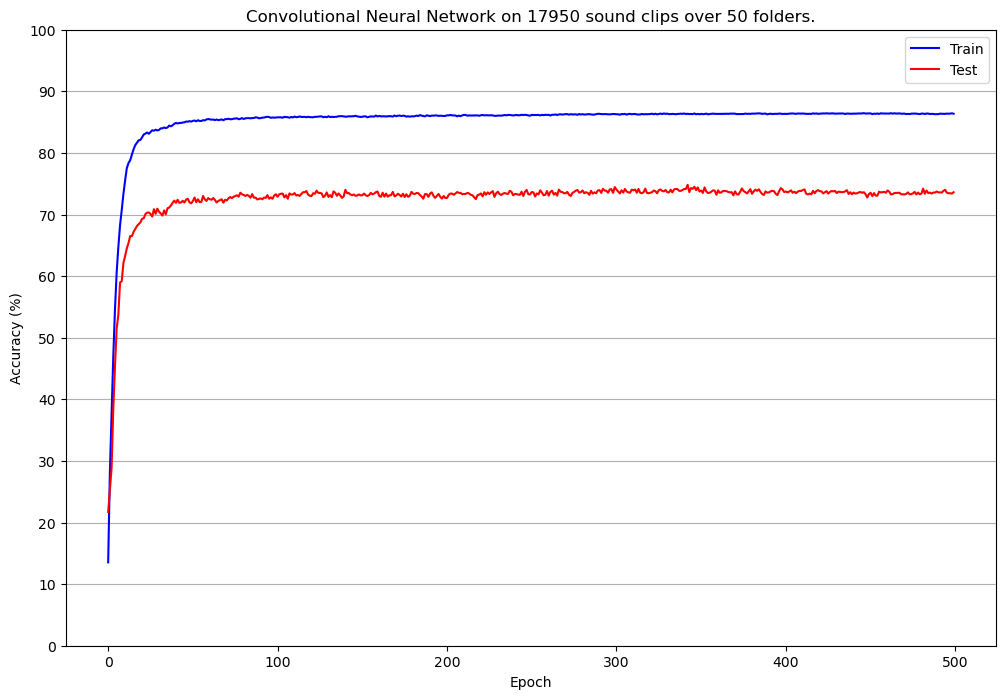

In [22]:
# to avoid extreme overfitting:
# - dropout rate between 0.2-0.5 seems good
# - learning rate around 0.001 provides best training rate without overfitting
# - train in larger batches, 64 upwards seems good
# - most seem to plateau around 200 epochs, maybe reduce to reduce total training time

reset_seed()

model = TestModel(input_shape=x_train.shape, dropout_rate=dropout_rate)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss() # since we are classifying.
loss_fn = loss_fn.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate) # adam has no momentum, but DOES have weight decay

print(sum(p.numel() for p in model.parameters() if p.requires_grad))

train_loss_hist, train_acc_hist, test_acc_hist, best_model = train_model(model, loss_fn, optimizer, epochs, batch_size, save_best_to_file=save_best_to_file, experimental=experimental)

In [23]:
# investigate TOP 5 ERROR of the model.
# compare with top 1 error (accuracy)

model.load_state_dict(best_model)
model.eval()

# get predictions for ALL testing data
k = 5
test_pred = model(x_test)
test_pred_top_k = torch.topk(test_pred, k=k, dim=1)[1]

total = 0
in_top_k = 0
for index, value in enumerate(y_test):
    if value in test_pred_top_k[index]: in_top_k += 1

    total += 1

top_k_accuracy = in_top_k * 100 / total

print(f"Top {k} Accuracy: {top_k_accuracy:.03f}%")

Top 5 Accuracy: 79.164%


In [24]:
folder_df["file"].value_counts()

file
XC416747.mp3    200
XC811631.ogg    156
XC294611.ogg    128
XC136060.ogg    123
XC350953.ogg    120
               ... 
XC503747.ogg      1
XC636428.ogg      1
XC173595.mp3      1
XC193421.mp3      1
XC476563.ogg      1
Name: count, Length: 877, dtype: int64

In [25]:
accuracy_df = pd.DataFrame(data=[y_test.cpu().numpy(), test_pred_top_k.cpu().numpy()], index=["actual", "pred"]).transpose()
accuracy_df["in_top_5"] = [1 if accuracy_df.iloc[i, 0] in accuracy_df.iloc[i, 1] else 0 for i in range(len(accuracy_df.index))]
folder_top_5 = accuracy_df.groupby(by="actual").aggregate(func=np.sum)["in_top_5"].values
folder_counts = accuracy_df.groupby(by="actual").aggregate(func=np.size)["in_top_5"].values
accuracy_df = pd.DataFrame(data=[folder_top_5, folder_counts], index=["in_top_5", "count"]).transpose()
accuracy_df["top_5_accuracy"] = round(accuracy_df["in_top_5"] * 100 / accuracy_df["count"], 2)
accuracy_df.sort_values(by="top_5_accuracy")

,in_top_5,count,top_5_accuracy
12,0,75,0.00
18,0,79,0.00
29,0,70,0.00
34,0,60,0.00
41,0,83,0.00
42,0,78,0.00
48,51,67,76.12
27,52,68,76.47
39,51,66,77.27
47,61,75,81.33


In [26]:
# takes in a whole file as input, feeds into the model, performs sequential aggregation
# gives a single output based on aggregation strategy
def test_file(folder, file_path):
    global sample_rate, split_length, model
    samples = []
    
    # load file data and resample to sample_rate if necessary
    file_data, file_sample_rate_hz = torchaudio.load(uri=file_path, channels_first=True)
    if file_sample_rate_hz != sample_rate:
        file_data = torchaudio.functional.resample(file_data, orig_freq=file_sample_rate_hz, new_freq=sample_rate)

    # convert all audio into mono (1 channel) if audio is stereo (2 channels)
    if file_data.shape[0] == 2: file_data = file_data.mean(dim=0)
    else: file_data = file_data.flatten()

    # get total number of X second splits
    total_splits = floor(len(file_data) / int(sample_rate * split_interval_secs))
    
    # convert file data into mel-spectrogram fourier transform for feeding into CNN
    n_fft = 1024

    mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate = sample_rate, power=2, n_fft=n_fft)
    amp_to_db_transform = torchaudio.transforms.AmplitudeToDB(stype="amplitude", top_db=80)
    mel_spec_data_db = amp_to_db_transform(mel_spec_transform(file_data))
    
    # if file is at least X seconds.
    if total_splits >= 1:
        split_length = min(mel_spec_data_db.shape[1] // total_splits, split_length)
        mel_spec_splits = np.arange(0, mel_spec_data_db.shape[1], split_length)
        for i in range(len(mel_spec_splits) - 1):
            start = mel_spec_splits[i]
            end = mel_spec_splits[i + 1]

            mel_spec_split = mel_spec_data_db[:, start:end]

            var = np.var(mel_spec_split.numpy())
            mean = np.mean(mel_spec_split.numpy())

            #if var > variance_threshold:
            # automatically keep anything ABOVE mean db level
            if mean > mean_threshold:
                samples.append(mel_spec_split.reshape(1, 128, -1).numpy())
            else:
                # if mean is LOW, only include those with variance ABOVE threshold
                if var > variance_threshold:
                    samples.append(mel_spec_split.reshape(1, 128, -1).numpy())
            
    else:
        return None

    samples = torch.Tensor(np.array(samples)).to(device)

    preds = model(samples)


    '''
    # sequential aggregation via max value output per index/folder
    seq_aggregation_results = {}
    m = torch.max(preds, dim=1)
    for index, folder in folder_key.items():
        seq_aggregation_results[folder] = max(seq_aggregation_results.get(folder, 0), 0)

    for index in range(len(m.indices)):
        folder_index = m.indices[index].item()
        value = m.values[index].item()
    
        seq_aggregation_results[folder_key[folder_index]] = max(seq_aggregation_results.get(folder_key[folder_index], 0), value)
    '''

    
    # Ax[classes] sized array, A = number of splits in file
    # sequential aggregation via summation (appears to be the best solution right now, but barely by much)
    seq_aggregation_result = torch.sum(preds, dim=0)
    prediction_order = [folder_key[i] for i in torch.topk(seq_aggregation_result, k=len(seq_aggregation_result)).indices.cpu().numpy() if folder_key[i] != "SILENT"]
    location = prediction_order.index(folder) + 1 # because of zero index, adjust to make it 1-indexed
    
    return location, prediction_order
    
    
    '''
    # sequential aggregation via ranking
    # - assign each folder a rank (using topk) for each prediction, starting from 0 or 1.
    # - sum the ranks over each folder
    # - arrange each rank sum from smallest to largest
    # - smaller sums = higher predictions
    folder_ranks = {}
    
    for pred in preds:
        ranks = torch.topk(pred, k=5).indices.cpu().numpy()

        rank_value = 1 # can start at 0 as well. #1 makes sense for "first place"
        for rank in ranks:
            key = folder_key[rank]
            folder_ranks[key] = folder_ranks.get(key, 0) + rank_value

            rank_value += 1

    folder_ranks = dict(sorted(folder_ranks.items(), key=lambda x: x[1]))
    
    location = list(folder_ranks.keys()).index(folder) + 1 if folder in list(folder_ranks.keys()) else 50000

    return location, list(folder_ranks.keys())
    '''

In [27]:
is_valid_file = False

valid_files = valid_files = set([l.replace("\n", "") for l in open(f"rating_thresholds_at_least_10_classes/min_rating_{int(min_rating * 2)}.txt").readlines()])

while not is_valid_file:
    random_folder = base_path + random.choice([i for i in folder_key.values() if i != "SILENT"]) + "/"
    random_file = random_folder + random.choice(os.listdir(random_folder))

    if random_file.split("/")[-2] + "/" + random_file.split("/")[-1] in valid_files:
        is_valid_file = True

print(random_file)

test_file(random_folder.split("/")[-2], random_file)

/mnt/lustre/peprmint/train_audio/yehcar1/XC151433.ogg


(16,
 ['scbwre1',
  'redcro',
  'dowwoo',
  'rerswa1',
  'cobtan1',
  'barswa',
  'indbun',
  'comloo',
  'mitpar',
  'blhpar1',
  'amepip',
  'brnjay',
  'sheowl',
  'peflov',
  'zebdov',
  'yehcar1',
  'cubthr',
  'amtspa',
  'spotow',
  'buwwar',
  'insowl1',
  'annhum',
  'bkskit1',
  'bkbmag1',
  'litegr',
  'verdin',
  'comyel',
  'brubru1',
  'blkfra',
  'combuz1',
  'whiwre1',
  'yebsap',
  'leater1',
  'piebus1',
  'yehbla',
  'royter1',
  'lotduc',
  'banswa',
  'logshr',
  'combul2',
  'brncre',
  'whbman1',
  'compau',
  'pirfly1',
  'ocbfly1',
  'oliwoo1',
  'eucdov',
  'phaino',
  'mawthr1',
  'grycat'])

In [28]:
# do above but for EVERY SINGLE FILE in the classes used

valid_files = set([l.replace("\n", "") for l in open(f"rating_thresholds_at_least_10_classes/min_rating_{int(min_rating * 2)}.txt").readlines()])
sequential_aggregation_results = {}

folder_counter = 1
for folder in folder_key.values():

    if folder == "SILENT":
        folder_counter += 1
        continue

    folder_path = base_path + folder + "/"

    folder_length = len(os.listdir(folder_path))
    file_counter = 0
    for file in (progress_bar := tqdm(os.listdir(folder_path))):
        file_counter += 1
        progress_bar.set_description(f"{folder_counter}/{len(folder_key.keys())} - {folder} - {file_counter}/{folder_length}")
        
        file_path = folder_path + file

        if folder + "/" + file in valid_files:
            result = test_file(folder, file_path)
            if result:
                sequential_aggregation_results[folder] = sequential_aggregation_results.get(folder, []) + [result[0]]

    folder_counter += 1


50/51 - grycat - 301/301: 100%|██████████| 301/301 [00:04<00:00, 70.41it/s]


In [29]:
rows = []

for folder in sequential_aggregation_results.keys():
    row = {}

    results = sequential_aggregation_results[folder]

    row["folder"] = folder
    row["total_files"] = len(results)
    row["in_top_1_percentage"] = round(sum([1 if result == 1 else 0 for result in results]) * 100 / len(results), 2)
    row["in_top_5_percentage"] = round(sum([1 if result <= 5 else 0 for result in results]) * 100 / len(results), 2)

    rows.append(row)

sequential_aggregation_df = pd.DataFrame(rows)

sequential_aggregation_df["top_1_product"] = sequential_aggregation_df["total_files"] * sequential_aggregation_df["in_top_1_percentage"]
sequential_aggregation_df["top_5_product"] = sequential_aggregation_df["total_files"] * sequential_aggregation_df["in_top_5_percentage"]

print(sum(sequential_aggregation_df["top_1_product"]) / sum(sequential_aggregation_df["total_files"]))
print(sum(sequential_aggregation_df["top_5_product"]) / sum(sequential_aggregation_df["total_files"]))

sequential_aggregation_df.sort_values(by="in_top_5_percentage", ascending=False)


2.948568376068376
13.71821794871795


,folder,total_files,in_top_1_percentage,in_top_5_percentage,top_1_product,top_5_product
0,dowwoo,27,0.00,74.07,0.00,1999.89
2,cobtan1,26,7.69,69.23,199.94,1799.98
1,rerswa1,66,0.00,60.61,0.00,4000.26
3,barswa,232,13.79,55.17,3199.28,12799.44
35,scbwre1,31,45.16,48.39,1399.96,1500.09
4,indbun,40,5.00,42.50,200.00,1700.00
7,blhpar1,31,29.03,38.71,899.93,1200.01
32,yehbla,23,4.35,26.09,100.05,600.07
20,bkskit1,67,4.48,25.37,300.16,1699.79
23,verdin,31,0.00,22.58,0.00,699.98
